In [1]:
import os,sys,random,math,re,time,cv2,matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append('./code')  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import grapes

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class InferenceConfig(grapes.GrapeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [3]:
# Load validation set for testing

print("Loading validation set...")
dataset_val = grapes.GrapeDataset()
dataset_val.load_grape('./dataset','val')
dataset_val.prepare()

Loading validation set...


In [5]:
# Import the model
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir='./')

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_grapes.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\AgelosK\grapes-recognition\mask_rcnn_grapes.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 2048.00000  float64
gt_class_id              shape: (25,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (25, 4)               min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 25)      min:    0.00000  max:    1.00000  float64


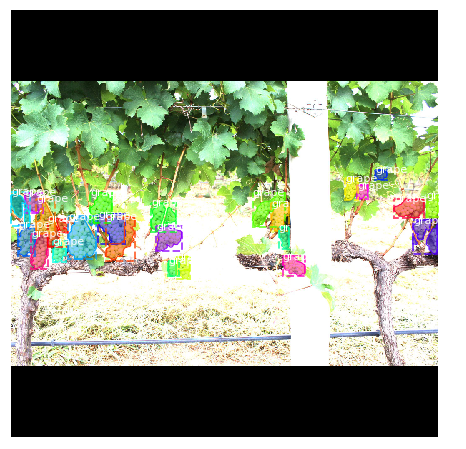

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


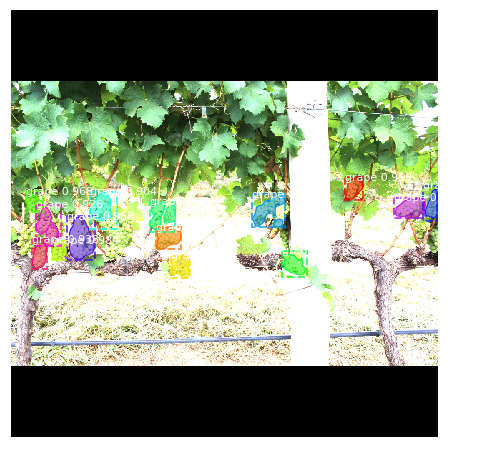

In [9]:
# Test on a random image from val test
# some images are heavily augmented (with rain,fog or extreme contrast/brightness) and hence it might
# be really hard to get great results. 
# To test on non-augmented natural images load test set in the next-next cell.
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(dataset_val, inference_config,
                                                                                    image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_val.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    +
    APs.append(AP)
    print("h")
print("mAP: ", np.mean(APs))

In [18]:
# Test your own images. Test set has non-augmented images from validation set. 

print("Loading test set...")
dataset_test = grapes.GrapeDataset()
dataset_test.load_grape('./dataset','test')
dataset_test.prepare()

Loading test set...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


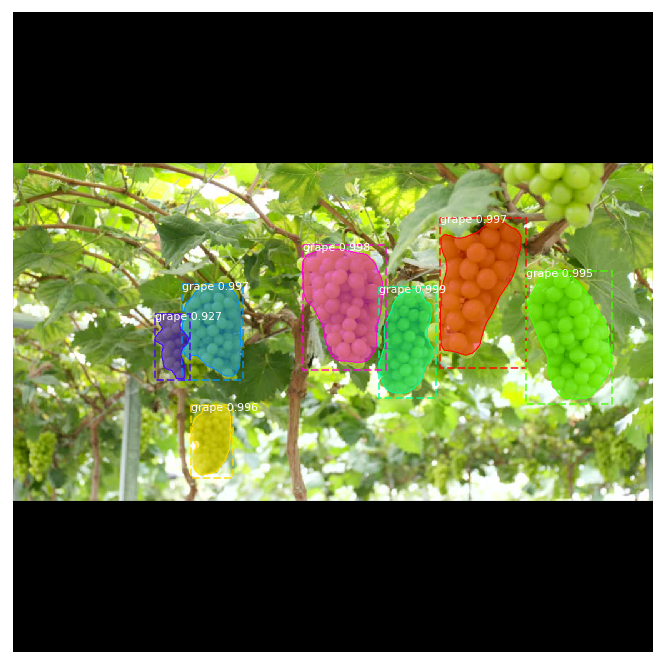

In [19]:
# Add image x.jpg and if no mask is available create a x.npz empty file

image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(dataset_test, inference_config,
                                                                                    image_id, use_mini_mask=False)


#If mask is empty comment this
#visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,dataset_test.class_names, figsize=(12, 12))

results = model.detect([original_image], verbose=0)
r = results[0]

#If mask is emtpy comment this
#AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                                                      r["rois"], r["class_ids"], r["scores"], r['masks'])

x = visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_test.class_names, r['scores'], figsize=(12,12))


#print("AP:",AP)
#print("Precision:",precisions)
#print("Recall:",np.round(recalls,2))